# ALX Movie Recommendation Project 2024 - NoteBook

#### Project working platform
https://www.kaggle.com/competitions/alx-movie-recommendation-project-2024/overview

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv
/kaggle/input/alx-movie-recommendation-project-2024/movies.csv
/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv
/kaggle/input/alx-movie-recommendation-project-2024/train.csv
/kaggle/input/alx-movie-recommendation-project-2024/test.csv
/kaggle/input/alx-movie-recommendation-project-2024/tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/links.csv


**Imports**

In [23]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

**Loading Data**

In [24]:
train_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
movies_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')
imdb_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv')
test_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
links_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/links.csv')
tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/tags.csv')
genome_scores = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv')
sample_submissions = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv')

In [25]:
sample_submissions.shape[0]

5000019

**EDA**

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837
Movies Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None
   movieId                               title  \
0        1                  

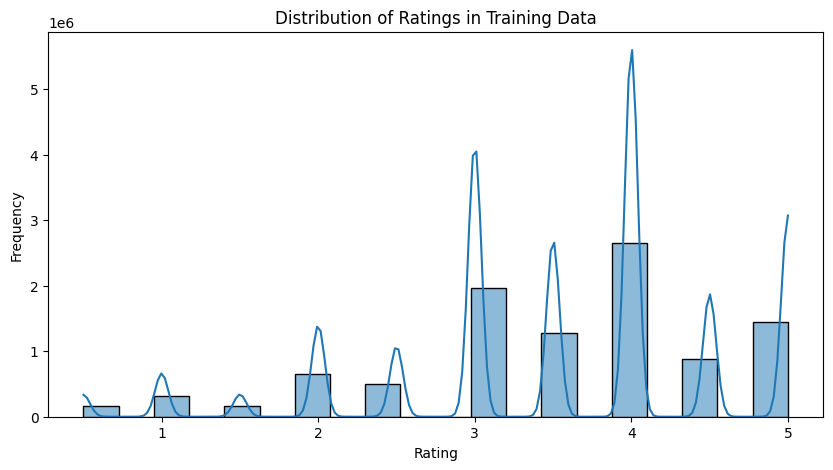

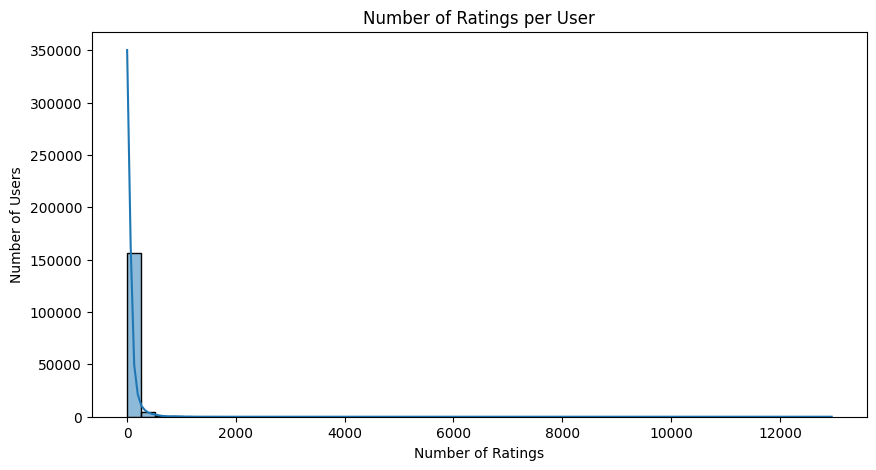

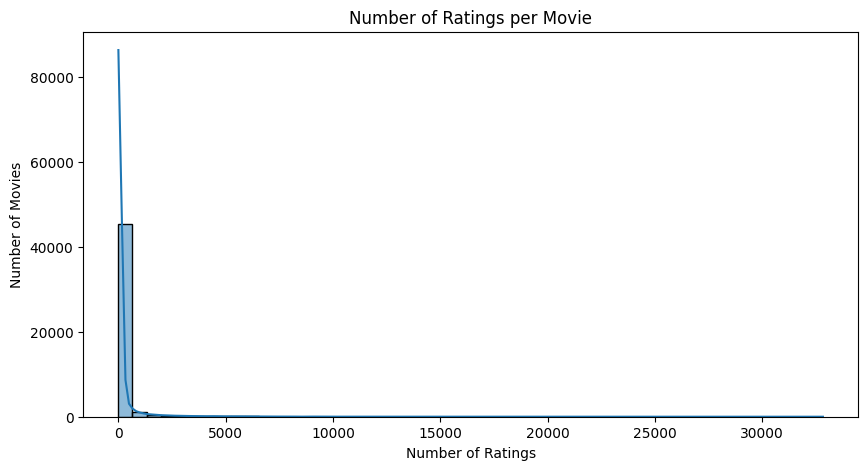

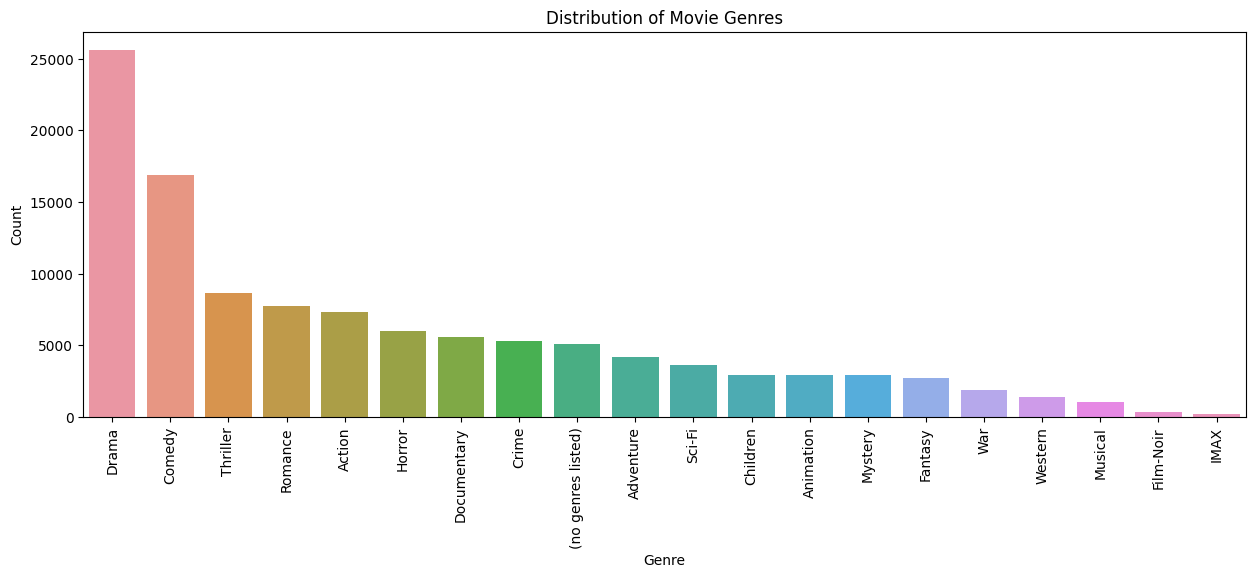

In [26]:
# Display basic information and the first few rows of each dataframe
print("Train Data:")
print(train_df.info())
print(train_df.head())

print("Movies Data:")
print(movies_df.info())
print(movies_df.head())

print("IMDB Data:")
print(imdb_df.info())
print(imdb_df.head())

print("Test Data:")
print(test_df.info())
print(test_df.head())

print("Links Data:")
print(links_df.info())
print(links_df.head())

print("Tags Data:")
print(tags.info())
print(tags.head())

print("Genome Scores Data:")
print(genome_scores.info())
print(genome_scores.head())

print("Genome Tags Data:")
print(genome_tags.info())
print(genome_tags.head())

print("Sample Submissions:")
print(sample_submissions.info())
print(sample_submissions.head())

# Checking for missing values
print("Missing values in Train Data:")
print(train_df.isnull().sum())

print("Missing values in Movies Data:")
print(movies_df.isnull().sum())

print("Missing values in IMDB Data:")
print(imdb_df.isnull().sum())

print("Missing values in Test Data:")
print(test_df.isnull().sum())

print("Missing values in Links Data:")
print(links_df.isnull().sum())

print("Missing values in Tags Data:")
print(tags.isnull().sum())

print("Missing values in Genome Scores Data:")
print(genome_scores.isnull().sum())

print("Missing values in Genome Tags Data:")
print(genome_tags.isnull().sum())

# Rating distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['rating'], bins=20, kde=True)
plt.title("Distribution of Ratings in Training Data")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Number of ratings per user
ratings_per_user = train_df.groupby('userId').size()
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

# Number of ratings per movie
ratings_per_movie = train_df.groupby('movieId').size()
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

# Genres analysis
genres = movies_df['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(15, 5))
sns.barplot(x=genres.index, y=genres.values)
plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


> **Data preparation**

> > **Handling Missisng values**

In [27]:
# Check for missing values
print("Missing values in movies_df:")
print(movies_df.isnull().sum())

print("Missing values in imdb_df:")
print(imdb_df.isnull().sum())

# Fill missing values in imdb_df
imdb_df.fillna('', inplace=True)

Missing values in movies_df:
movieId    0
title      0
genres     0
dtype: int64
Missing values in imdb_df:
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


> > **Process Genres**

In [28]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']], columns=['movieId', 'genres'])

# Split genres separated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a separate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres], columns=['movieId', 'genres'])

# One-hot encode genres
movies_genres_onehot = pd.concat([movies_genres, pd.get_dummies(movies_genres['genres'])], axis=1)
movies_genres_onehot.drop('genres', axis=1, inplace=True)

# Aggregate genres by movieId
movies_genres_onehot = movies_genres_onehot.groupby('movieId').sum().reset_index()

# Merge movies_genres_onehot with movies_df
movies_merged = pd.merge(movies_df, movies_genres_onehot, on='movieId', how='left')


> > **Merge with Train and Test Data**

In [29]:
# Merge the movies metadata with the train and test data
train_merged = pd.merge(train_df, movies_merged, on='movieId', how='left')
test_merged = pd.merge(test_df, movies_merged, on='movieId', how='left')

# Aggregate user features (e.g., mean rating, rating count)
user_features = train_df.groupby('userId').agg(
    mean_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).reset_index()

# Merge user features with train and test data
train_merged = pd.merge(train_merged, user_features, on='userId', how='left')
test_merged = pd.merge(test_merged, user_features, on='userId', how='left')

# Display the first few rows of the prepared train and test data
print("Prepared Train Data:")
print(train_merged.head())

print("Prepared Test Data:")
print(test_merged.head())

Prepared Train Data:
   userId  movieId  rating   timestamp  \
0    5163    57669     4.0  1518349992   
1  106343        5     4.5  1206238739   
2  146790     5459     5.0  1076215539   
3  106362    32296     2.0  1423042565   
4    9041      366     3.0   833375837   

                                               title  \
0                                   In Bruges (2008)   
1                 Father of the Bride Part II (1995)   
2  Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...   
3     Miss Congeniality 2: Armed and Fabulous (2005)   
4  Wes Craven's New Nightmare (Nightmare on Elm S...   

                          genres  (no genres listed)  Action  Adventure  \
0    Comedy|Crime|Drama|Thriller                   0       0          0   
1                         Comedy                   0       0          0   
2           Action|Comedy|Sci-Fi                   0       1          0   
3         Adventure|Comedy|Crime                   0       0          1   
4  Drama|Horro

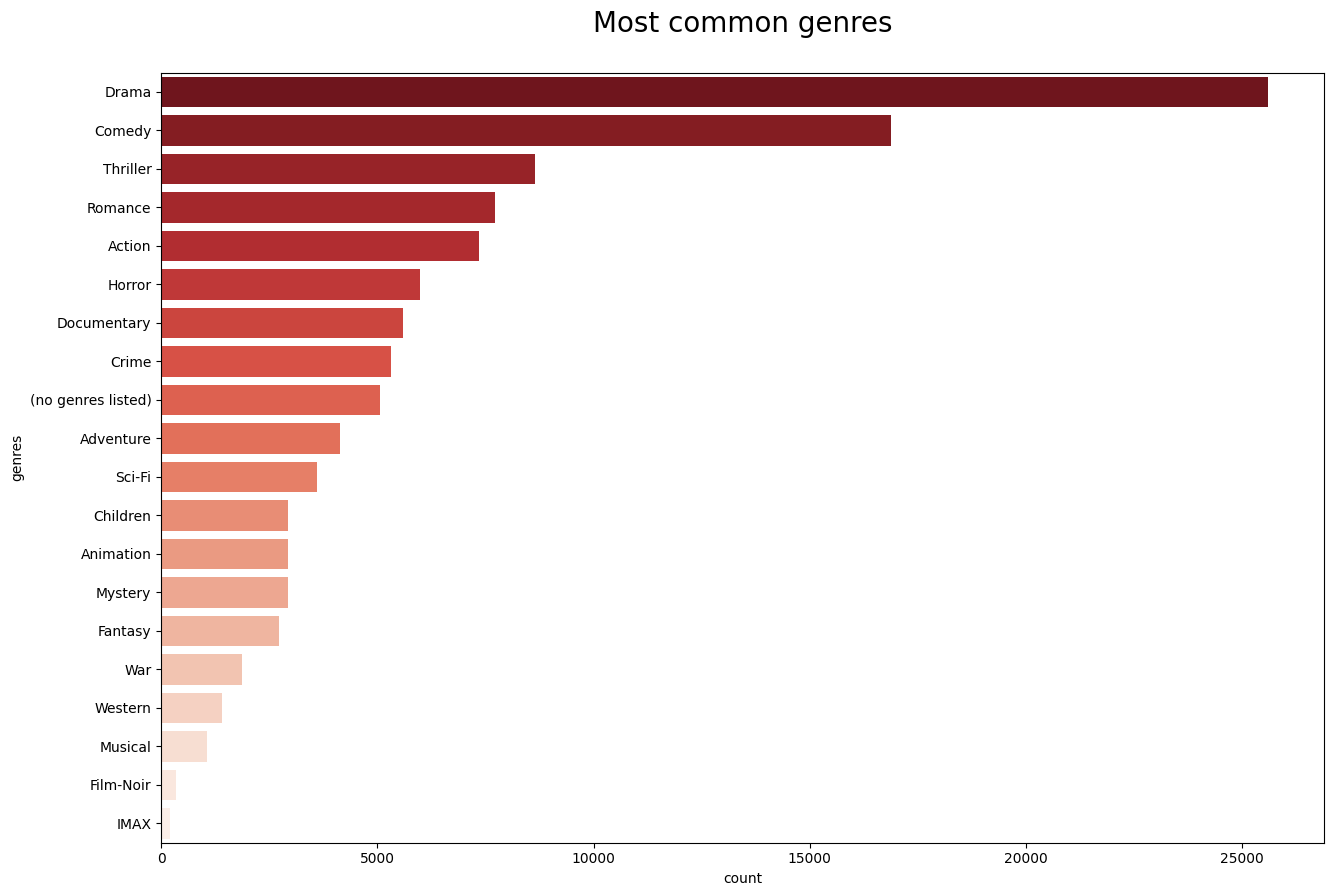

In [30]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

**Modelling Phase**

In [37]:
from surprise import Reader, Dataset

# Prepare the data for the surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()


**Building and evaluating the model**

In [38]:
from surprise import SVD

# Initialize the SVD model
svd_model = SVD()

# Train the model on the full training set
svd_model.fit(trainset)


In [39]:
from surprise.model_selection import cross_validate

# Evaluate the model using cross-validation
cross_val_results = cross_validate(svd_model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8344  0.8336  0.8340  0.8342  0.8339  0.8340  0.0003  
Fit time          196.79  202.98  206.11  204.76  207.35  203.60  3.70    
Test time         32.58   31.96   21.40   31.63   32.42   30.00   4.31    


**Make a Recommendation Function**

In [40]:
def recommend_movies(user_id, num_recommendations=10):
    # Get a list of all movie IDs
    all_movie_ids = train_df['movieId'].unique()
    
    # Get the list of movies the user has already rated
    rated_movies = train_df[train_df['userId'] == user_id]['movieId'].unique()
    
    # Create a list of movie IDs that the user has not rated
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]
    
    # Predict ratings for all unrated movies
    predictions = [svd_model.predict(user_id, movie_id) for movie_id in unrated_movies]
    
    # Sort the predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get the top N recommendations
    top_recommendations = predictions[:num_recommendations]
    
    # Return the recommended movie IDs and their estimated ratings
    return [(pred.iid, pred.est) for pred in top_recommendations]

# Example usage
user_id = 1  # Replace with a user ID from your dataset
recommendations = recommend_movies(user_id)
print(f"Top recommendations for user {user_id}: {recommendations}")


Top recommendations for user 1: [(114627, 4.562228858274037), (179135, 4.55822723984541), (1232, 4.544757651296909), (179173, 4.512658981420278), (171011, 4.510271908047412), (116897, 4.489770983044044), (92475, 4.4692799379404375), (142115, 4.468013884982727), (6896, 4.44087253691722), (68874, 4.420921760335317)]


**Generate my_submission.csv File**

In [41]:
# Prepare the test data
testset_for_prediction = test_df[['userId', 'movieId']].copy()
testset_for_prediction['rating'] = 0  # Dummy rating column to match the input format

# Convert the test set to a list of tuples
testset_for_prediction = list(testset_for_prediction.itertuples(index=False, name=None))

# Generate predictions
predictions = svd_model.test(testset_for_prediction)

In [42]:
# Prepare the submission dataframe
submission = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions], columns=['userId', 'movieId', 'rating'])

# Create the 'Id' column by concatenating 'userId' and 'movieId'
submission['Id'] = submission['userId'].astype(str) + '_' + submission['movieId'].astype(str)

# Select only the 'Id' and 'rating' columns for the submission
submission = submission[['Id', 'rating']]

# Save the submission to a CSV file
submission.to_csv('my_submission_2.csv', index=False)


In [43]:
submission_df = pd.read_csv('/kaggle/working/my_submission_2.csv')

In [47]:
submission_df.shape[0]

5000019